In [39]:
import math
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import animation, rc
from qbstyles import mpl_style
from utils import *

plt.style.use("seaborn-white")
plt.rcParams.update({"pdf.fonttype": "truetype"})

mpl_style(dark=False)
np.set_printoptions(suppress=True, precision = 2)

# **Deep Reinforcement Learning for Supply Chain and Price Optimization**

This is the first part of the tutorial focused on price optimization. We define an environment with a complex price-demand function and implement DQN that jointly optimizes the price schedule for several time steps ahead.

- [Detailed Description](https://blog.griddynamics.com/deep-reinforcement-learning-for-supply-chain-and-price-optimization/)
- [Paper](https://ewrl.files.wordpress.com/2018/09/ewrl_14_2018_paper_44.pdf)

# **Environment: Assymetric Price Response and Hi-Lo Pricing**

Traditional price optimization assumes a simple known parametric price-response function. Optimization under such an assumption is relatively straightforward, even in case of inventory constraints or other factors. Many basic formulations can be solved analytically, and many others can be solved numerically. The challenge is typically in estimating the price-response function, not in the optimization.

In some cases, however, optimization also becomes a challenge. This section introduces an example of a price-demand function with temporal dependencies. The optimal price schedule for such a function has a **sawtooth** shape.

The revenue optimization problem can be defined as below:

\begin{aligned} 
\max \ \ & \sum_t \sum_j p_j \cdot q(t, j) \cdot x_{tj} \\ 
\text{subject to} \ \ & \sum_j x_{tj} = 1, \quad \text{for all } t \\ 
&\sum_t \sum_j q(t, j) \cdot x_{tj} = c \\ 
&x_{tj} \in {0,1} 
\end{aligned}

where:
- $t$ - time intervals
- $j$ - price levels
- $p_{j}$ - price at level $j$
- $q(t, j)$ - demand at time $t$ at level $j$
- $c$ - total stock
- $x_{tj}$ - binary variable equal to 1 if price level $p_{j}$ is assigned at time $t$, 0 otherwise

there are two constraints:
- each time interval has only one allowed price
- all demands sum up to the available stock

This is an integer programming problem that can be solved using conventional optimization libraries.

# **Temporal Dependency of Demand and Price**

In the real world, demand depends not only on the current absolute price level but can also be impacted by the magnitude of **recent price changes** and even **past prices**. Price decrease can create a temporary **demand splash**, while the price increase can create a **sticker shock** and a temporary drop in demand. The impact of price changes can also be **asymmetric**.


\begin{aligned} 
q(p_t, p_{t-1}) &= q_0 - k\cdot p_t - a\cdot s( (p_t - p_{t-1})^+) + b\cdot s( (p_t - p_{t-1})^-) \\ 
\end{aligned}

where:
- $(p_t - p_{t-1})^+$ = $p_t - p_{t-1}$ if $p_t$ > $p_{t-1}$, else $0$
- $(p_t - p_{t-1})^-$ = $p_t - p_{t-1}$ if $p_t$ < $p_{t-1}$, else $0$
- $p_{t}$ - price at time $t$
- $q_{0}$, $k$ - corresponds to a linear demand model with intercept $q_{0}$, price slope $k$
- $a$, $b$ - sensitivity to positive and negative price changes
- $s$ - shock function to specify a non-linear dependency between price change and demand (for illustration purposes, we can assume that $s(x)$ = $\sqrt{x}$

Price Levels: (99,):
[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180
 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270
 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360
 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450
 455 460 465 470 475 480 485 490 495]

Price Changes: (25,):
[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15
 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7 ]


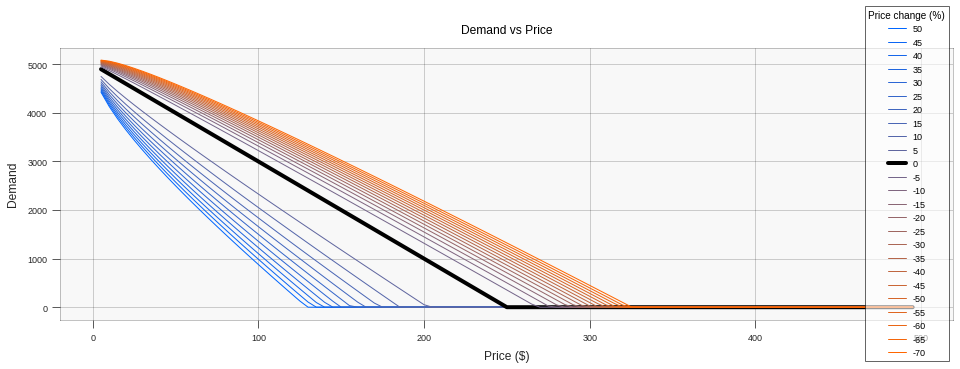

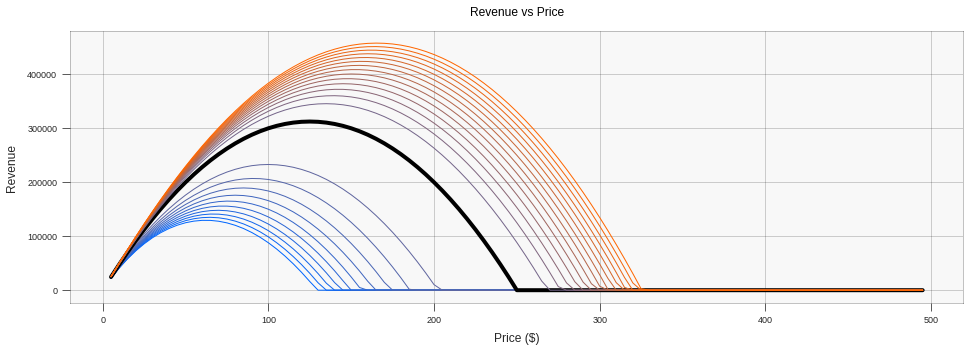

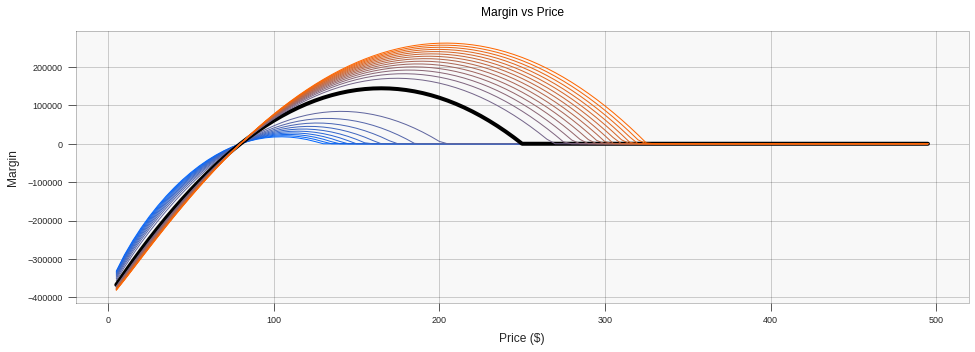

In [160]:
# environment simulator

T = 20                                     # time steps in the price schedule
price_max = 500                  # maximum valid price
price_step = 5                      # minimum price change possible
price_inc_perc = 0.5           # maximum percentage price increase
price_dec_perc = 0.75        # minimum percentage price increase
q_0 = 5000                           # intercept in the demand function q_t
k = 20                                    # slope in the demand function q_t
cost = 80                            # item cost
a_q = 300                            # coefficient of price increase
b_q = 100                            # coefficient of price decrease

def p_rectified(x):
    return max(0, x)

def n_rectified(x):
    return max(0, -x)

def shock(x):
    return np.sqrt(x)

# demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return p_rectified(q_0 - k * p_t - a*shock(p_rectified(p_t - p_t_1)) + b*shock(n_rectified(p_t - p_t_1)))

# margin at time step t
def margin_t(p_t, p_t_1, q_0, k, a, b, cost):
    return  (p_t - cost) * q_t(p_t, p_t_1, q_0, k, a, b)

# total margin for the price vector p over the len(p) time steps
def margin_total(p, q_0, k, a, b, cost):
    return margin_t(p[0], p[0], q_0, k, 0, 0, cost) + sum(map(lambda t: margin_t(p[t], p[t-1], q_0, k, a, b, cost), range(len(p))))

# partial bindings for better reabability 
def margin_t_resp(p_t, p_t_1):
    return np.round(margin_t(p_t, p_t_1, q_0, k, a_q, b_q, cost))

def margin_total_resp(p):
    return np.round(margin_total(p, q_0, k, a_q, b_q, cost))


price_levels = np.arange(price_step, price_max, price_step)
price_changes = np.arange(1 - price_inc_perc, 1 + price_dec_perc, 0.05)
demand_matrix = np.zeros((len(price_levels), len(price_changes)))
revenue_matrix = np.zeros((len(price_levels), len(price_changes)))
margin_matrix = np.zeros((len(price_levels), len(price_changes)))

for i, p_l in enumerate(price_levels):
    for j, p_c in enumerate(price_changes):
        demand_matrix[i, j] = q_t(p_t = p_l, p_t_1 = p_l * p_c, q_0 = q_0, k = k, a = a_q, b = b_q)
        revenue_matrix[i, j] = p_l * demand_matrix[i, j]
        margin_matrix[i, j] = margin_t_resp(p_t = p_l, p_t_1 = p_l * p_c)
        
print(f"Price Levels: {np.shape(price_levels)}:\n{price_levels}\n\nPrice Changes: {np.shape(np.int_(np.round((1-price_changes)*100)))}:\n{price_changes}")

# plot price-demand functions

plt.figure(figsize=(16, 5))
for i, p_c in enumerate(price_changes):
    if math.isclose(p_c, 1.0):
        color = 'black'
        linewidth = 4.0
    else:
        p_norm = (p_c - min(price_changes))/ (max(price_changes) - min(price_changes))
        color = (p_norm, 0.4, 1 - p_norm)
        linewidth = 1.0
    plt.plot(price_levels, demand_matrix[:, i], c=color, linewidth = linewidth)
plt.xlabel("Price ($)")
plt.ylabel("Demand")
plt.title("Demand vs Price")
plt.legend(np.int_(np.round((1-price_changes)*100)), loc='right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.show()

plt.figure(figsize=(16, 5))
for i, p_c in enumerate(price_changes):
    if math.isclose(p_c, 1.0):
        color = 'black'
        linewidth = 4.0
    else:
        p_norm = (p_c - min(price_changes))/ (max(price_changes) - min(price_changes))
        color = (p_norm, 0.4, 1 - p_norm)
        linewidth = 1.0
    plt.plot(price_levels, revenue_matrix[:, i], c=color, linewidth = linewidth)
plt.xlabel("Price ($)")
plt.ylabel("Revenue ")
plt.title("Revenue vs Price")
plt.show()

plt.figure(figsize=(16, 5))
for i, p_c in enumerate(price_changes):
    if math.isclose(p_c, 1.0):
        color = 'black'
        linewidth = 4.0
    else:
        p_norm = (p_c - min(price_changes))/ (max(price_changes) - min(price_changes))
        color = (p_norm, 0.4, 1 - p_norm)
        linewidth = 1.0
    plt.plot(price_levels, margin_matrix[:, i], c=color, linewidth = linewidth)
plt.xlabel("Price ($)")
plt.ylabel("Margin")
plt.title("Margin vs Price")
plt.show()

Price increase "deflate" the baseline margin response, while price decreases "inflate" it.

# **Optimum Price and Margin for Static Price Level**

In [161]:
margins = np.array([margin_total_resp(np.repeat(price, T)) for price in price_levels])
price_opt_static = price_levels[np.argmax(margins)]
print(f'Optimal price is {price_opt_static}, achieved margin is {margins[np.argmax(margins)]}')

Optimal price is 165, achieved margin is 3034500.0


# **Optimum Price and Margin for Dynamic Price Levels**

## **Sequential Greedy Search**

[165 495 215 180 170 165 495 215 180 170 165 495 215 180 170 165 495 215
 180 170]
Achieved profit is 3566604.0


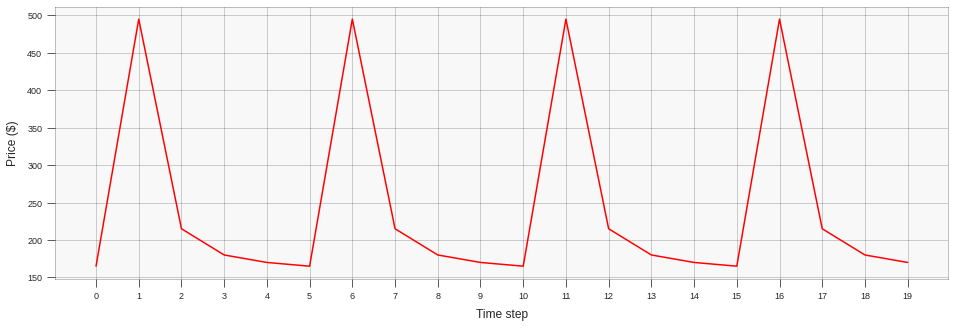

In [162]:
def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    margins = np.array([ margin_total_resp(p) for p in p_grid ])
    return price_levels[ np.argmax(margins) ]

p_opt = np.repeat(price_opt_static, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_levels, t)
    p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {margin_total_resp(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')
plt.show()